In [1]:
%matplotlib inline
#Libraries
import sys
#sys.path.append('/neurospin/meg/meg_tmp/Calculation_Pedro_2014/scripts/decoding')
sys.path.append('/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/scripts_git/Calc_MEG/decoding/')
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
from scipy.stats import wilcoxon

#Personal functions
from initDirs import dirs

from jr.plot import base, gat_plot, pretty_gat, pretty_decod, pretty_slices
from jr.stats import gat_stats, parallel_stats


In [2]:
#Define custom wilcoxon
def _my_wilcoxon(X):
    out = wilcoxon(X)
    return out[1]

In [3]:
#Basics
#Paths

#List of parameters
subjects = ['s03', 's04', 's05', 's06', 's07', 's08', 's09', 's10',
            's11', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's22']

#subjects = ['s03']

baselinecorr = 'no'
dec_method = 'class'
dec_scorer = 'accuracy'
gatordiag = 'gat'

conditions = [['vsa', 'addsub']]

chance = .5 #chance-level

ttp = [-0.2] #starting time point
toi = [[0.3, 0.6], [0.8, 2.532]] #training time points over which to average

In [6]:
#Initialize results
all_scores = []
all_diagonals = []
all_ypred = []

In [7]:
####################Load data####################
for c, cond in enumerate(conditions):
    for s, subject in enumerate(subjects):
        print('loading subject ' + subject)
        fname = dirs['ind_result'] + cond[0] + '_' + cond[1] + '/' + subject + '_' + cond[0] + '_' + cond[1] + '_' + 'results' + '_' + dec_method + '_' + dec_scorer + '_' + gatordiag + '_' + baselinecorr + '.npy'
        #fname = dirs['ind_result'] + cond[0] + '_' + cond[1] + '/' + subject + '_' + cond[0] + '_' + cond[1] + '_' + 'results' + '_' + dec_method + '_' + dec_scorer + '_' + gatordiag + '.npy'
        results = np.load(fname)
        results = results.tolist()
        all_scores.append(results['score'])
        all_diagonals.append(results['diagonal'])
        all_ypred.append(results['y_pred'])
        times = results['times_calc']
score = results['score']
diagonal = results['diagonal']
ypred = results['y_pred']
all_scores = np.array(all_scores) #shape: subjects*n_cond, training_times, testing_times
all_diagonals = np.array(all_diagonals)  
#all_ypred = np.array(all_ypred)  

loading subject s03
loading subject s04
loading subject s05
loading subject s06
loading subject s07
loading subject s08
loading subject s09
loading subject s10
loading subject s11
loading subject s13
loading subject s14
loading subject s15
loading subject s16
loading subject s17
loading subject s18
loading subject s19
loading subject s22


In [8]:
#Reshape and average data
all_scores = np.reshape(all_scores, (len(conditions), len(subjects), score.shape[0], score.shape[1])) #n_cond, n_subj, training_times, testing_times
all_diagonals = np.reshape(all_diagonals, (len(conditions), len(subjects), diagonal.shape[0]))

group_scores = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
sem_group_scores = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
group_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))
sem_group_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))

for c, cond in enumerate(conditions):
    group_scores[c, :, :] = np.mean(all_scores[c, :, :, :], 0)
    sem_group_scores[c, :, :] = stats.sem(all_scores[c, :, :, :], 0)

    group_diagonal[c, :] = np.mean(all_diagonals[c, :, :], 0)
    sem_group_diagonal[c, :] = stats.sem(all_diagonals[c, :, :], 0)

In [9]:
np.shape(all_scores)

(1, 17, 401, 626)

In [10]:
#Select subset of time window
#Identify the index
ind = np.where(time == ttp[0])
ind = int(ind[0][0])

#Cut all of the data
time = time[ind :]
all_diagonals = all_diagonals[:, :, ind :]
all_scores = all_scores[:, :, ind :, ind :]

NameError: name 'time' is not defined

In [ ]:
#Compute time averages for diagonal
timeBins = [[0.1, 0.3], [0.3, 0.6], [0.6, 1.6], [1.6, 2.532]]
group_diagonal_AVG = np.zeros((len(conditions), len(timeBins), len(subjects)))
sem_group_diagonal_AVG = np.zeros((len(conditions), len(timeBins)))

for c, cond in enumerate(conditions):
    for tb, timebin in enumerate(timeBins):
        #Identify the index
        ind1 = np.where(time == timeBins[tb][0])
        ind1 = int(ind1[0][0])
        ind2 = np.where(time == timeBins[tb][1])
        ind2 = int(ind2[0][0])

        group_diagonal_AVG[c, tb, :] = np.mean(all_diagonals[c, :,  ind1 : ind2], 1)
        sem_group_diagonal_AVG[c, tb] = stats.sem(np.mean(all_diagonals[c, :, ind1 : ind2], 1), 0)

In [11]:
#Compute stats for each condition separately
p_values_gat = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_gat_fdr = np.zeros((len(conditions), all_scores.shape[2], all_scores.shape[3]))
p_values_diagonal = np.zeros((len(conditions), all_diagonals.shape[2]))
p_values_diagonal_fdr = np.zeros((len(conditions), all_diagonals.shape[2]))


for c, cond in enumerate(conditions):
    print('calculating stats for condition' + '_' + cond[0] + '_' + cond[1])
    p_values_gat[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_gat_fdr[c, :, :] = parallel_stats(all_scores[c, :, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    p_values_diagonal[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
    p_values_diagonal_fdr[c, :] = parallel_stats(all_diagonals[c, :, :] - chance, function = _my_wilcoxon, correction = 'FDR', n_jobs = -1)
    
    #Get one-sided p-value
    p_values_diagonal[c, :] = p_values_diagonal[c, :]/2.
    p_values_diagonal_fdr[c, :] = p_values_diagonal_fdr[c, :]/2.

calculating stats for condition__vsa__addsub


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   12.5s remaining:   20.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   13.5s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.0s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   14.1s remaining:   23.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   15.1s remaining:    9.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   16.6s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


In [ ]:
 #Compute stats for averaged diagonal
p_values_group_diagonal_AVG = np.zeros((len(conditions), len(timeBins)))

for c, cond in enumerate(conditions):
    for tb, timebin in enumerate(timeBins):
        p_values_group_diagonal_AVG[c, tb] = parallel_stats(group_diagonal_AVG[c, tb, :] - chance, function = _my_wilcoxon, correction = False, n_jobs = -1)
        p_values_group_diagonal_AVG[c, tb] = p_values_group_diagonal_AVG[c, tb]/2.   

s03
['vsa', 'addsub']


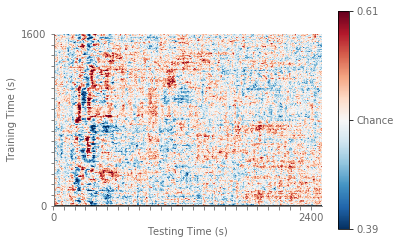

s04
['vsa', 'addsub']


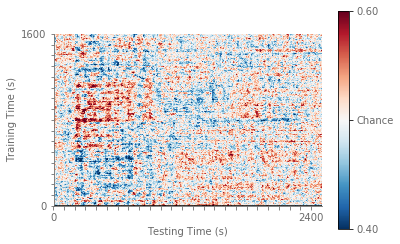

s05
['vsa', 'addsub']


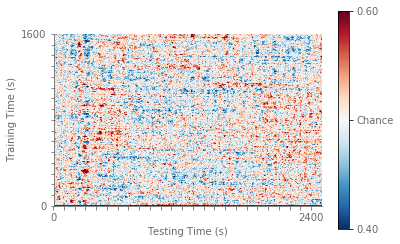

s06
['vsa', 'addsub']


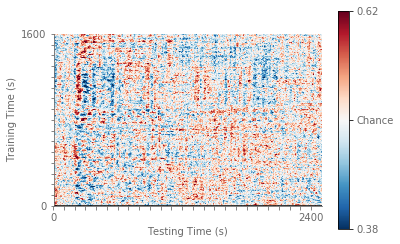

s07
['vsa', 'addsub']


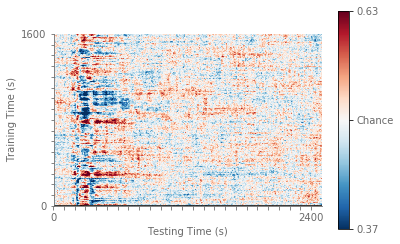

s08
['vsa', 'addsub']


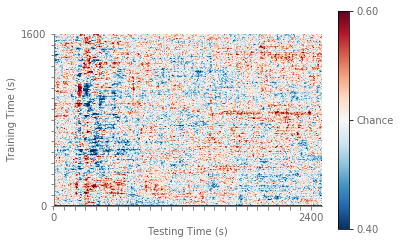

s09
['vsa', 'addsub']


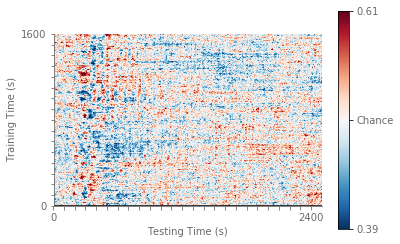

s10
['vsa', 'addsub']


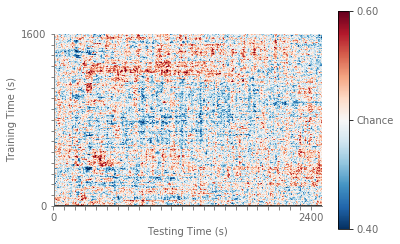

s11
['vsa', 'addsub']


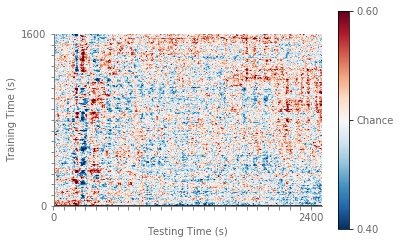

s13
['vsa', 'addsub']


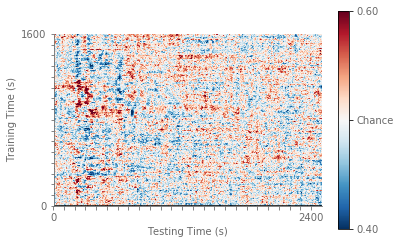

s14
['vsa', 'addsub']


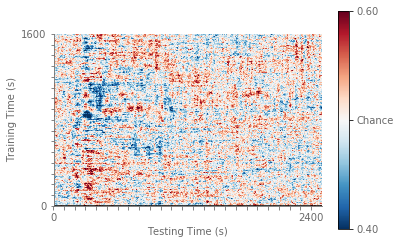

s15
['vsa', 'addsub']


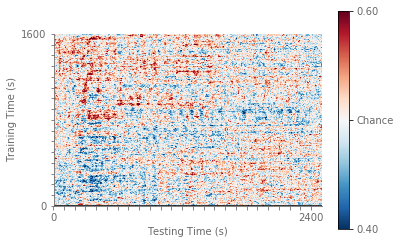

s16
['vsa', 'addsub']


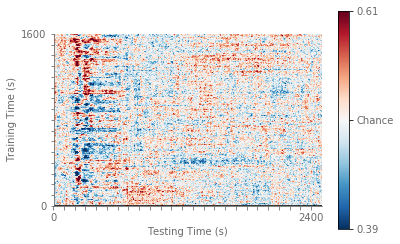

s17
['vsa', 'addsub']


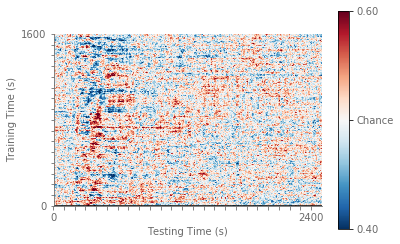

s18
['vsa', 'addsub']


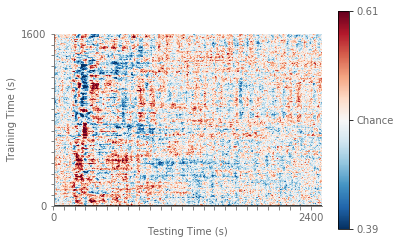

s19
['vsa', 'addsub']


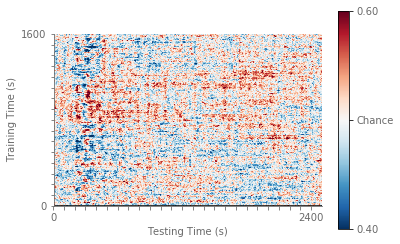

s22
['vsa', 'addsub']


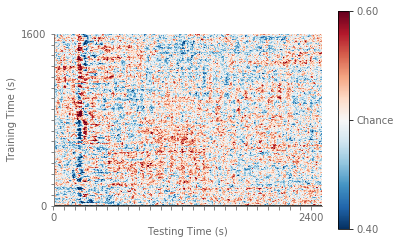

In [12]:
#Plot original GAT - individual subjects
for c, cond in enumerate(conditions):
    for s, sub in enumerate(subjects):
        print(sub)
        print(cond)
        pretty_gat(all_scores[c, s, :, :], chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, test_times = None)
        plt.show()

['vsa', 'addsub']


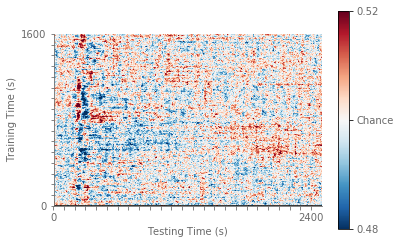

In [13]:
#Plot original GAT - group
for c, cond in enumerate(conditions):
    print(cond)
    pretty_gat(group_scores[c, :, :], chance = chance, ax = None, sig = None, cmap = 'RdBu_r',
             clim = None, colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, test_times = None)
    plt.show()

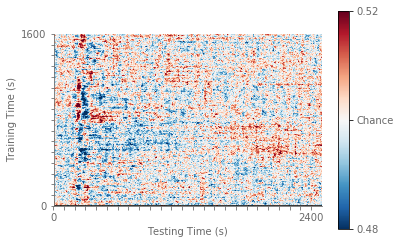

In [14]:
#Plot GAT with uncorrected p values
for c, cond in enumerate(conditions):
    classLines = [None, None, toi, toi]
    pretty_gat(group_scores[c, :, :], chance = .5, ax = None, sig = None, cmap = 'RdBu_r',
             colorbar = True, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, test_times = None)
    fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT.tif'
    #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

['vsa', 'addsub']


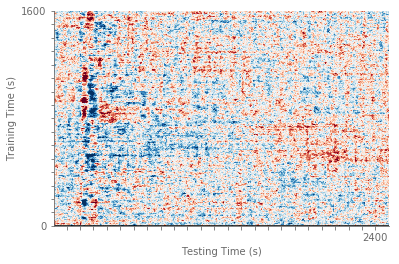

In [15]:
#Plot GAT with corrected p values - only contour
for c, cond in enumerate(conditions):
    classLines = [None, None, toi, toi]
    print(cond)
    pretty_gat(group_scores[c, :, :], chance = chance, ax = None, sig = p_values_gat[c,:], cmap = 'RdBu_r',
             colorbar = None, xlabel = 'Testing Time (s)', 
             ylabel = 'Training Time (s)', sfreq = 250, test_times = None)
    fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-uncorrectedGAT_contour.tif'
    #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [ ]:
#Plot diagonal with uncorrected p values
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(conditions):
        print (cond)
        print(times[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=times, chance=chance, ax=None, sig=p_values_diagonal[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02)
        fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-uncorrectedDiag_smooth.tif'
        #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

In [ ]:
times

In [ ]:
#Plot decoding with corrected p values
#colors = ['dodgerblue', 'darkturquoise', 'darkred', 'crimson']
colors = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

for c, cond in enumerate(conditions):
        print (cond)
        print(time[np.where(p_values_diagonal[c, :] < .05)])
        pretty_decod(all_diagonals[c, :, :], times=time, chance=chance, ax=None, sig=p_values_diagonal_fdr[c, :], width=20.,
                 color='k', fill=False, xlabel='Times (s)', sfreq=250, alpha=.02, scat=True, line=False, smoothWindow=8, lim = [-0.05, 0.15], thickness = 2, thicknessScat=40, schrift = 14)
        fname = dirs['gp_result'] + '/' + cond[0] + '_' + cond[1] + '-correctedDiag_smooth.tif'
        #plt.savefig(fname, format = 'tif', dpi = 300, bbox_inches = 'tight')
        
        plt.show()

In [ ]:
####################Plot diagonal in time bins####################
#Load important libraries
import matplotlib.pyplot as plt

#Define important variables
n_bins = len(timeBins)
font = {'fontname': 'Arial', 'fontsize': 14}

colors_blind = [(0.0, 0.4470588235294118, 0.6980392156862745),
                 (0.0, 0.6196078431372549, 0.45098039215686275),
                 (0.8352941176470589, 0.3686274509803922, 0.0),
                 (0.8, 0.4745098039215686, 0.6549019607843137),
                 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
                 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
               (0.0, 0.4470588235294118, 0.6980392156862745),
               (0.0, 0.6196078431372549, 0.45098039215686275),
                (0.8352941176470589, 0.3686274509803922, 0.0),]

xLabels = ['Early', 'P3b', 'bDis', 'aDis']

x = np.arange(n_bins)
index = np.arange(n_bins)

for c, cond in enumerate(conditions):
    ax = plt.gca()
    print(cond)
        
    ax.bar(x, np.mean(group_diagonal_AVG[c, :, :], 1), alpha = 0.8, color = colors_blind)
        
    print(np.mean(group_diagonal_AVG[c, 0, :]), 1)
    print(sem_group_diagonal_AVG[c, 0])
        
    print(np.mean(group_diagonal_AVG[c, 1, :]), 1)
    print(sem_group_diagonal_AVG[c, 1])
    
    print(np.mean(group_diagonal_AVG[c, 2, :]), 1)
    print(sem_group_diagonal_AVG[c, 2])
    
    print(np.mean(group_diagonal_AVG[c, 3, :]), 1)
    print(sem_group_diagonal_AVG[c, 3])
        
    print(p_values_group_diagonal_AVG[c, 0])
    print(p_values_group_diagonal_AVG[c, 1])
    print(p_values_group_diagonal_AVG[c, 2])
    print(p_values_group_diagonal_AVG[c, 3])
        
    for pos, y, err, color in zip(x, np.mean(group_diagonal_AVG[c, :, :], 1), sem_group_diagonal_AVG[c, :], colors_blind):
        ax.errorbar(pos + 0.4, y, err, lw = 2, capsize = 5, color = color)

    #Plot chance level
    plt.axhline(0.0, color = 'k', ls = '--')

    #Take care of axes
    ax.margins(0.05) #spacing at the 
    ax.set_xticks(index + 0.4)
    ax.set_xticklabels(xLabels)
    ax.set_ylim([-0.1, 0.2])
    plt.show()